In [1]:
pip install findspark

In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=ac7c8454d7669b8b74a0cea9ac487c05370ea61cda55a75d7f15951782a475b6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np

In [4]:
spark = SparkSession.builder \
    .appName("Productos") \
    .getOrCreate()


In [5]:
# Crear un rango de fechas
fechas = pd.date_range(start='2022-01-01', periods=100, freq='D')

# Formatear las fechas a 'dd-MM-yyyy'
fechas = fechas.strftime('%d-%m-%Y')

# Categorías
categorias = ['Comida para perros', 'Comida para gatos', 'Comida para aves', 'Comida para peces']

# Generar datos aleatorios para las ventas, ingresos, promociones y descuentos
np.random.seed(0)  # Para reproducibilidad
ventas = np.random.randint(1, 100, size=100)
ingresos = np.round(ventas * np.random.uniform(5, 20, size=100), 2)  # Ingresos con máximo 2 decimales
promociones = np.random.randint(0, 10, size=100)
descuentos = np.where(ventas >= 75, 0.20, np.where(ventas >= 50, 0.15, np.where(ventas >= 25, 0.10, 0.05)))
categorias_aleatorias = np.random.choice(categorias, size=100)

# Crear el DataFrame de pandas
df_pandas = pd.DataFrame({
    'Fecha': fechas,
    'Categoría': categorias_aleatorias,
    'Ventas': ventas,
    'Ingresos': ingresos,
    'Promociones': promociones,
    'Descuentos': descuentos
})

# Convertir el DataFrame de pandas a un DataFrame de Spark
df = spark.createDataFrame(df_pandas)

# Mostrar el esquema del DataFrame de Spark
df.printSchema()

# Mostrar el DataFrame de Spark
df.show()


root
 |-- Fecha: string (nullable = true)
 |-- Categoría: string (nullable = true)
 |-- Ventas: long (nullable = true)
 |-- Ingresos: double (nullable = true)
 |-- Promociones: long (nullable = true)
 |-- Descuentos: double (nullable = true)

+----------+------------------+------+--------+-----------+----------+
|     Fecha|         Categoría|Ventas|Ingresos|Promociones|Descuentos|
+----------+------------------+------+--------+-----------+----------+
|01-01-2022|Comida para perros|    45|  865.96|          9|       0.1|
|02-01-2022| Comida para gatos|    48|  717.02|          7|       0.1|
|03-01-2022|  Comida para aves|    65|  338.23|          7|      0.15|
|04-01-2022|  Comida para aves|    68|   975.3|          5|      0.15|
|05-01-2022|Comida para perros|    68| 1027.13|          1|      0.15|
|06-01-2022|  Comida para aves|    10|  195.79|          2|      0.05|
|07-01-2022| Comida para gatos|    84| 1526.52|          2|       0.2|
|08-01-2022| Comida para peces|    22|  278.18|

In [6]:
df.show(10)

+----------+------------------+------+--------+-----------+----------+
|     Fecha|         Categoría|Ventas|Ingresos|Promociones|Descuentos|
+----------+------------------+------+--------+-----------+----------+
|01-01-2022|Comida para perros|    45|  865.96|          9|       0.1|
|02-01-2022| Comida para gatos|    48|  717.02|          7|       0.1|
|03-01-2022|  Comida para aves|    65|  338.23|          7|      0.15|
|04-01-2022|  Comida para aves|    68|   975.3|          5|      0.15|
|05-01-2022|Comida para perros|    68| 1027.13|          1|      0.15|
|06-01-2022|  Comida para aves|    10|  195.79|          2|      0.05|
|07-01-2022| Comida para gatos|    84| 1526.52|          2|       0.2|
|08-01-2022| Comida para peces|    22|  278.18|          8|      0.05|
|09-01-2022| Comida para peces|    37|  215.92|          1|       0.1|
|10-01-2022| Comida para peces|    88| 1035.53|          5|       0.2|
+----------+------------------+------+--------+-----------+----------+
only s

In [7]:
df.printSchema()

root
 |-- Fecha: string (nullable = true)
 |-- Categoría: string (nullable = true)
 |-- Ventas: long (nullable = true)
 |-- Ingresos: double (nullable = true)
 |-- Promociones: long (nullable = true)
 |-- Descuentos: double (nullable = true)



In [8]:
df.count()

100

In [9]:
df.describe().show()

+-------+----------+------------------+-----------------+-----------------+-----------------+-------------------+
|summary|     Fecha|         Categoría|           Ventas|         Ingresos|      Promociones|         Descuentos|
+-------+----------+------------------+-----------------+-----------------+-----------------+-------------------+
|  count|       100|               100|              100|              100|              100|                100|
|   mean|      NULL|              NULL|            47.85|         616.2039|             4.39|              0.122|
| stddev|      NULL|              NULL|27.01566137624544|452.4415962396347|2.912512192717358|0.05565042405022353|
|    min|01-01-2022|  Comida para aves|                1|              9.7|                0|               0.05|
|    max|31-03-2022|Comida para perros|               92|          1797.17|                9|                0.2|
+-------+----------+------------------+-----------------+-----------------+-------------

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


In [11]:
feature_cols = ["Promociones", "Descuentos"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df)
df_features.show()

+----------+------------------+------+--------+-----------+----------+----------+
|     Fecha|         Categoría|Ventas|Ingresos|Promociones|Descuentos|  features|
+----------+------------------+------+--------+-----------+----------+----------+
|01-01-2022|Comida para perros|    45|  865.96|          9|       0.1| [9.0,0.1]|
|02-01-2022| Comida para gatos|    48|  717.02|          7|       0.1| [7.0,0.1]|
|03-01-2022|  Comida para aves|    65|  338.23|          7|      0.15|[7.0,0.15]|
|04-01-2022|  Comida para aves|    68|   975.3|          5|      0.15|[5.0,0.15]|
|05-01-2022|Comida para perros|    68| 1027.13|          1|      0.15|[1.0,0.15]|
|06-01-2022|  Comida para aves|    10|  195.79|          2|      0.05|[2.0,0.05]|
|07-01-2022| Comida para gatos|    84| 1526.52|          2|       0.2| [2.0,0.2]|
|08-01-2022| Comida para peces|    22|  278.18|          8|      0.05|[8.0,0.05]|
|09-01-2022| Comida para peces|    37|  215.92|          1|       0.1| [1.0,0.1]|
|10-01-2022| Com

In [12]:
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

In [13]:
# Crear una función para entrenar y evaluar modelos
def train_and_evaluate(train_data, test_data, label_col):
    lr = LinearRegression(labelCol=label_col, featuresCol="features")
    lr_model = lr.fit(train_data)
    predictions = lr_model.transform(test_data)
    evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"RMSE para {label_col}: {rmse}")
    predictions.select("Fecha", label_col, "prediction").show(5)

In [14]:
variables_objetivo = ["Ventas", "Ingresos", "Promociones", "Descuentos"]
for variable in variables_objetivo:
    print(f"Predicciones para {variable}:")
    train_and_evaluate(train_data, test_data, variable)

spark.stop()

Predicciones para Ventas:
RMSE para Ventas: 7.10986989251139
+----------+------+------------------+
|     Fecha|Ventas|        prediction|
+----------+------+------------------+
|02-01-2022|    48| 37.30996668211204|
|04-01-2022|    68| 60.73077234247551|
|05-01-2022|    68| 60.45228481277994|
|07-02-2022|    20|13.401807844781308|
|10-02-2022|    33| 37.17072291726426|
+----------+------+------------------+
only showing top 5 rows

Predicciones para Ingresos:
RMSE para Ingresos: 194.20416688292522
+----------+--------+------------------+
|     Fecha|Ingresos|        prediction|
+----------+--------+------------------+
|02-01-2022|  717.02| 456.3998354944603|
|04-01-2022|   975.3| 799.9681548329734|
|05-01-2022| 1027.13| 807.3013326664852|
|07-02-2022|  311.12|125.66457736459273|
|10-02-2022|  539.27|460.06642441121625|
+----------+--------+------------------+
only showing top 5 rows

Predicciones para Promociones:
RMSE para Promociones: 2.4925121628537264e-15
+----------+-----------+-

In [16]:
import matplotlib.pyplot as plt

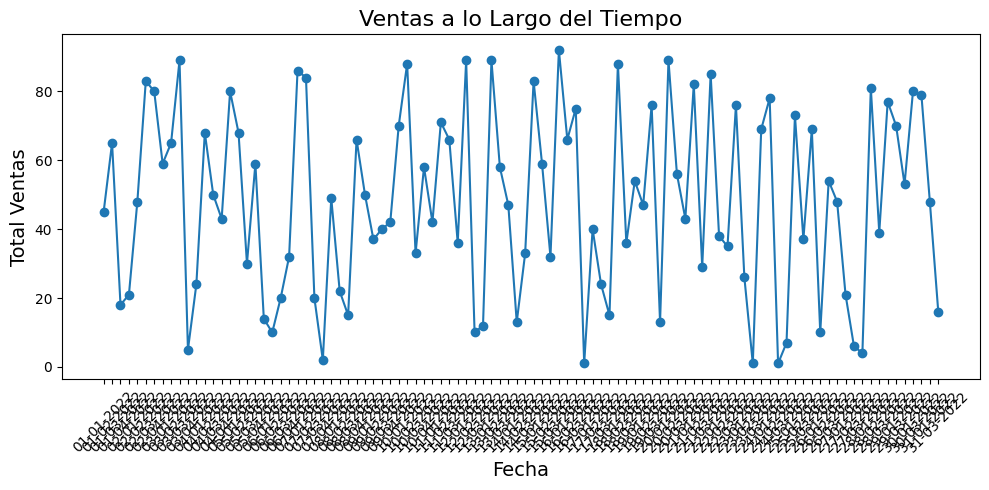

In [19]:
# Agrupar los datos por 'Fecha' y sumar las 'Ventas'
ventas_fecha = df_pandas.groupby('Fecha').agg({'Ventas': 'sum'}).reset_index()

# Graficar las ventas a lo largo del tiempo
plt.figure(figsize=(10, 5))
plt.plot(ventas_fecha['Fecha'], ventas_fecha['Ventas'], marker='o')
plt.title("Ventas a lo Largo del Tiempo", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Total Ventas", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('serie_temporal.png')
plt.show()

spark.stop()

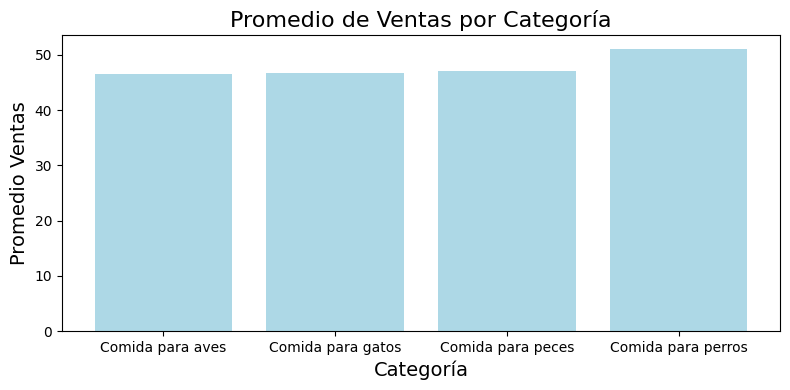

In [22]:
# Agrupar por categoría y calcular el promedio de ventas
segmentos = df_pandas.groupby('Categoría').agg({'Ventas': 'mean'}).reset_index()

# Graficar el promedio de ventas por categoría
plt.figure(figsize=(8, 4))
plt.bar(segmentos['Categoría'], segmentos['Ventas'], color='lightblue')
plt.title("Promedio de Ventas por Categoría", fontsize=16)
plt.xlabel("Categoría", fontsize=14)
plt.ylabel("Promedio Ventas", fontsize=14)
plt.tight_layout()
plt.savefig('segmentacion.png')
plt.show()

# Detener sesión de Spark
spark.stop()


In [23]:
import seaborn as sns


In [38]:
# Mostrar los primeros registros del DataFrame
print(df_pandas.head(10))

# Mostrar los tipos de datos de las columnas
print(df_pandas.dtypes)

# Mostrar valores únicos para las columnas numéricas
print("Valores únicos en 'Ventas':", df_pandas['Ventas'].unique())
print("Valores únicos en 'Ingresos':", df_pandas['Ingresos'].unique())
print("Valores únicos en 'Promociones':", df_pandas['Promociones'].unique())
print("Valores únicos en 'Descuentos':", df_pandas['Descuentos'].unique())


       Fecha           Categoría  Ventas  Ingresos  Promociones  Descuentos  \
0 2022-01-01  Comida para perros      45    865.96            9        0.10   
1 2022-01-02   Comida para gatos      48    717.02            7        0.10   
2 2022-01-03    Comida para aves      65    338.23            7        0.15   
3 2022-01-04    Comida para aves      68    975.30            5        0.15   
4 2022-01-05  Comida para perros      68   1027.13            1        0.15   
5 2022-01-06    Comida para aves      10    195.79            2        0.05   
6 2022-01-07   Comida para gatos      84   1526.52            2        0.20   
7 2022-01-08   Comida para peces      22    278.18            8        0.05   
8 2022-01-09   Comida para peces      37    215.92            1        0.10   
9 2022-01-10   Comida para peces      88   1035.53            5        0.20   

   Mes_Año  
0  2022-01  
1  2022-01  
2  2022-01  
3  2022-01  
4  2022-01  
5  2022-01  
6  2022-01  
7  2022-01  
8  2022-01  


In [39]:
# Verificar valores nulos y no válidos en las columnas numéricas
print("Valores nulos en 'Ventas':", df_pandas['Ventas'].isnull().sum())
print("Valores nulos en 'Ingresos':", df_pandas['Ingresos'].isnull().sum())
print("Valores nulos en 'Promociones':", df_pandas['Promociones'].isnull().sum())
print("Valores nulos en 'Descuentos':", df_pandas['Descuentos'].isnull().sum())

# Verificar valores que no pueden ser convertidos a numéricos
print(df_pandas[~df_pandas['Ventas'].apply(lambda x: isinstance(x, (int, float)))])
print(df_pandas[~df_pandas['Ingresos'].apply(lambda x: isinstance(x, (int, float)))])
print(df_pandas[~df_pandas['Promociones'].apply(lambda x: isinstance(x, (int, float)))])
print(df_pandas[~df_pandas['Descuentos'].apply(lambda x: isinstance(x, (int, float)))])

Valores nulos en 'Ventas': 0
Valores nulos en 'Ingresos': 0
Valores nulos en 'Promociones': 0
Valores nulos en 'Descuentos': 0
Empty DataFrame
Columns: [Fecha, Categoría, Ventas, Ingresos, Promociones, Descuentos, Mes_Año]
Index: []
Empty DataFrame
Columns: [Fecha, Categoría, Ventas, Ingresos, Promociones, Descuentos, Mes_Año]
Index: []
Empty DataFrame
Columns: [Fecha, Categoría, Ventas, Ingresos, Promociones, Descuentos, Mes_Año]
Index: []
Empty DataFrame
Columns: [Fecha, Categoría, Ventas, Ingresos, Promociones, Descuentos, Mes_Año]
Index: []


In [40]:
# Convertir las columnas a tipo numérico, forzando errores a NaN
df_pandas['Ventas'] = pd.to_numeric(df_pandas['Ventas'], errors='coerce')
df_pandas['Ingresos'] = pd.to_numeric(df_pandas['Ingresos'], errors='coerce')
df_pandas['Promociones'] = pd.to_numeric(df_pandas['Promociones'], errors='coerce')
df_pandas['Descuentos'] = pd.to_numeric(df_pandas['Descuentos'], errors='coerce')

# Revisa los datos nuevamente para asegurarte de que la conversión fue exitosa
print(df_pandas.dtypes)
print(df_pandas.isnull().sum())

Fecha          datetime64[ns]
Categoría              object
Ventas                  int64
Ingresos              float64
Promociones             int64
Descuentos            float64
Mes_Año             period[M]
dtype: object
Fecha          0
Categoría      0
Ventas         0
Ingresos       0
Promociones    0
Descuentos     0
Mes_Año        0
dtype: int64


In [41]:
# Reemplazar valores nulos con 0 o un valor adecuado
df_pandas.fillna({'Ventas': 0, 'Ingresos': 0, 'Promociones': 0, 'Descuentos': 0}, inplace=True)

# O eliminar filas con valores nulos
# df_pandas.dropna(subset=['Ventas', 'Ingresos', 'Promociones', 'Descuentos'], inplace=True)

# Verificar la limpieza de datos
print(df_pandas.isnull().sum())

Fecha          0
Categoría      0
Ventas         0
Ingresos       0
Promociones    0
Descuentos     0
Mes_Año        0
dtype: int64


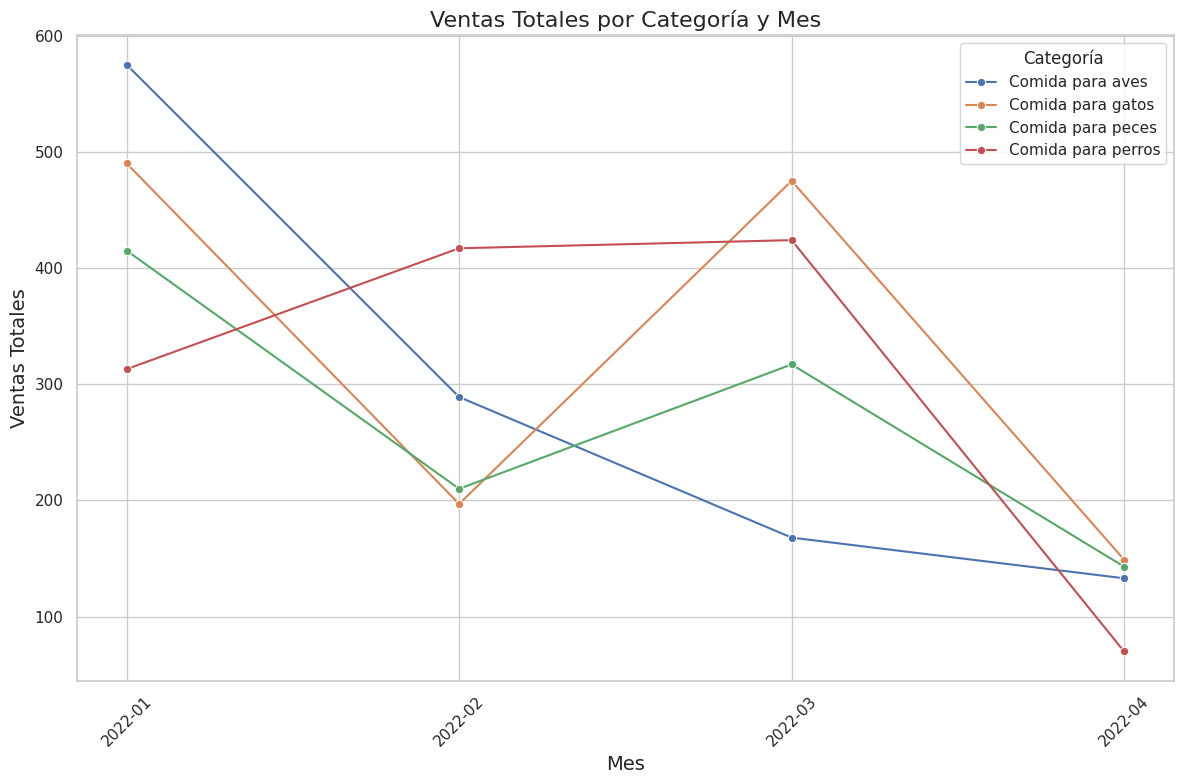

In [45]:
# Asegúrate de que 'Fecha' está en el formato correcto
df_pandas['Fecha'] = pd.to_datetime(df_pandas['Fecha'], format='%d-%m-%Y', errors='coerce')
df_pandas['Mes_Año'] = df_pandas['Fecha'].dt.to_period('M')

# Agrupar por categoría y mes, y sumar ventas
ventas_categoria_mes = df_pandas.groupby(['Categoría', 'Mes_Año']).agg({'Ventas': 'sum'}).reset_index()

# Crear un gráfico de líneas para cada categoría
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de que 'Mes_Año' está en el formato correcto de periodo
ventas_categoria_mes['Mes_Año'] = ventas_categoria_mes['Mes_Año'].astype(str)

# Crear un gráfico de líneas para cada categoría
plt.figure(figsize=(12, 8))
sns.lineplot(data=ventas_categoria_mes, x='Mes_Año', y='Ventas', hue='Categoría', marker='o')

plt.title("Ventas Totales por Categoría y Mes", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Ventas Totales", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.tight_layout()
plt.savefig('ventas_categoria_mes.png')
plt.show()

In [46]:
!pip install python-pptx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.2 MB/s eta 0:00:00


In [47]:
from pptx import Presentation
from pptx.util import Inches

# Crear presentación
prs = Presentation()

# Función para agregar un título y un subtítulo
def add_title_slide(title, subtitle):
    slide = prs.slides.add_slide(prs.slide_layouts[0])
    slide.shapes.title.text = title
    slide.placeholders[1].text = subtitle

# Diapositiva de título
add_title_slide("Análisis de Ventas de Comida para Mascotas", "Análisis completo de datos y resultados")

# Estadísticas Descriptivas
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Estadísticas Descriptivas"

# Asegúrate de que `desc_stats` es un DataFrame o Serie
desc_stats_text = desc_stats.to_string() if 'desc_stats' in locals() else 'No se han calculado estadísticas descriptivas aún.'
content = slide.shapes.add_textbox(Inches(0.5), Inches(1), Inches(8), Inches(5))
text_frame = content.text_frame
text_frame.text = desc_stats_text

# Gráfico de ventas por categoría
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Promedio de Ventas por Categoría"
slide.shapes.add_picture("/content/segmentacion.png", Inches(0.5), Inches(1), width=Inches(8))

# Análisis de Series Temporales
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Ventas a lo Largo del Tiempo"
slide.shapes.add_picture("/content/serie_temporal.png", Inches(0.5), Inches(1), width=Inches(8))

# Gráfica de ventas con descuentos
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Ventas por categoria"
slide.shapes.add_picture("/content/ventas_categoria_mes.png", Inches(0.5), Inches(1), width=Inches(8))

# Conclusiones Finales
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Conclusiones Finales"

conclusiones = (
    "1. Identificamos las categorías más vendidas y sus tendencias.\n"
    "2. El modelo predictivo proporciona información valiosa sobre ventas.\n"
    "3. Las promociones tienen un impacto significativo en las ventas.\n"
    "4. La optimización sugiere cantidades óptimas para maximizar ganancias."
)
content = slide.shapes.add_textbox(Inches(0.5), Inches(1), Inches(8), Inches(5))
text_frame = content.text_frame
text_frame.text = conclusiones

# Guardar la presentación
prs.save("Analisis_Ventas_Pets_Completo.pptx")